<a href="https://colab.research.google.com/github/opherdonchin/Grades-for-projects-anonymized/blob/main/Regression_analysis%20anonymized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for separating project grades from influence of grader

## Short description

Lots of projects. Lots of graders. Each grader, lots of sub-grades. Put them all together in a model

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

## Data loading and preprocessing

### Imports

In [12]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pymc3 &> /dev/null
    !pip install seaborn &> /dev/null
    !pip install arviz &> /dev/null
    !pip install chardet &> /dev/null
    !apt-get -qq install -y graphviz && pip install pydot &> /dev/null
    !pip install theano-pymc &> /dev/null

    !git clone https://github.com/opherdonchin/Grades-for-projects-anonymized
    !cd Grades-for-projects-anonymized

In [13]:
# Imports
# Python
import platform
import os.path
import pickle
import chardet

# Maths
import numpy as np
import pandas as pd
import scipy.stats as stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Bayes
import theano
import theano.tensor as tt
import xarray as xr
import pymc3 as pm
import arviz as az

az.style.use("arviz-darkgrid")


In [14]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v3.11.5


### Load data

In [15]:
url_raw_data = 'data/grades anonymous.csv'

with open(url_raw_data, 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
    
raw_data = pd.read_csv(url_raw_data, encoding = enc['encoding'], sep=",", on_bad_lines='skip')



In [16]:
raw_data.head()

,שם סטודנט,ציון,שם שופט,ציון.1
0,318476850,a,שופט 2,12
1,318476850,b,שופט 2,16
2,318476850,c,שופט 2,14
3,318476850,d,שופט 2,14
4,318476850,e,שופט 2,12


### Preprocess data

In [17]:
score_data = raw_data.copy()
score_data.columns = ['student', 'criterion', 'judge', 'grade']

data = score_data.groupby(['student','judge'])['grade'].sum().reset_index()


data['s_idx'], student_cats = pd.factorize(data['student'], sort=True)
data['j_idx'], judge_cats = pd.factorize(data['judge'], sort=True)

print(data.head())
data['grade'].describe()

     student   judge  grade  s_idx  j_idx
0  203677505  שופט 4     81      0     10
1  203677505  שופט 7     91      0     13
2  203677505  שופט 8     85      0     14
3  203677505  שופט 9     90      0     15
4  204922249  שופט 4     93      1     10


count     86.000000
mean      88.441860
std        6.321959
min       69.000000
25%       84.000000
50%       90.000000
75%       93.000000
max      100.000000
Name: grade, dtype: float64

## Model definition and fitting

### Define model

In [18]:
def regression_model(s_idx, j_idx, grade, s_cats, j_cats):
  mu_mu0 = 85
  sd_mu0 = 10
  sd_mus = 10
  sd_muj = 10
  sd_sd_g_sigma = 10
  lambda_g_nu = 1/10

  coords = {"students": s_cats, "judges": j_cats, "measures":np.arange(len(grade))}
  with pm.Model(coords=coords) as model:
    # Data
    s = pm.Data("s", s_idx, dims=["measures"])
    j = pm.Data("j", j_idx, dims=["measures"])

    # Priors
    mu_0 = pm.Normal('mu_0', mu=mu_mu0, sigma=sd_mu0)
    mu_s = pm.Normal('mu_s', mu=0, sigma=sd_mus, dims=["students"])
    mu_j = pm.Normal('mu_j', mu=0, sigma=sd_muj, dims=["judges"])

    # Regression variables
    g_mu = pm.Deterministic('g_mu', mu_0 + mu_s[s] + mu_j[j], dims=["measures"])
    g_sigma = pm.HalfNormal('g_sigma', sigma=sd_sd_g_sigma, dims=["judges"])
    # g_nu = pm.Exponential("g_nu", lam=lambda_g_nu)

    # Likelihood 
    pm.Normal('g_obs', mu=g_mu, sigma=g_sigma[j], observed=grade, dims=["measures"])
  return model


### Show model

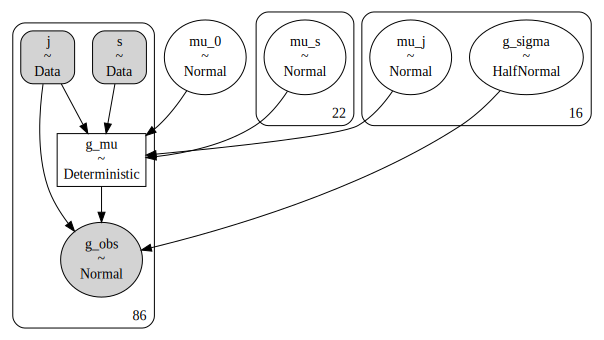

In [19]:
model = regression_model(data.s_idx, data.j_idx, data.grade, student_cats, judge_cats)
pm.model_to_graphviz(model)

### Sample model
Load samples from file if they are already there

In [20]:
trace_path = 'samples/grades anonymized.nc'
model_description = f'your model'
if not os.path.isfile(trace_path):
  print(f'Resampling {model_description}')
  model = regression_model(data.s_idx, data.j_idx, data.grade, student_cats, judge_cats)
  with model:
    idata = pm.sample(draws=5000, tune=4000, cores=5, target_accept=0.999, return_inferencedata=True)  
  print(f'Saving samples to {trace_path}')
  az.to_netcdf(idata, trace_path)
else:
  print(f'Loading samples for {model_description} from {trace_path}')
  idata = az.from_netcdf(trace_path)



Resampling your model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [g_sigma, mu_j, mu_s, mu_0]


Sampling 5 chains for 4_000 tune and 5_000 draw iterations (20_000 + 25_000 draws total) took 3888 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not matc

Saving samples to samples/grades anonymized.nc


## Diagnostics

### Show traces

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>],
       [<AxesSubplot:title={'center':'mu_s'}>,
        <AxesSubplot:title={'center':'mu_s'}>],
       [<AxesSubplot:title={'center':'mu_j'}>,
        <AxesSubplot:title={'center':'mu_j'}>],
       [<AxesSubplot:title={'center':'g_mu'}>,
        <AxesSubplot:title={'center':'g_mu'}>],
       [<AxesSubplot:title={'center':'g_sigma'}>,
        <AxesSubplot:title={'center':'g_sigma'}>]], dtype=object)

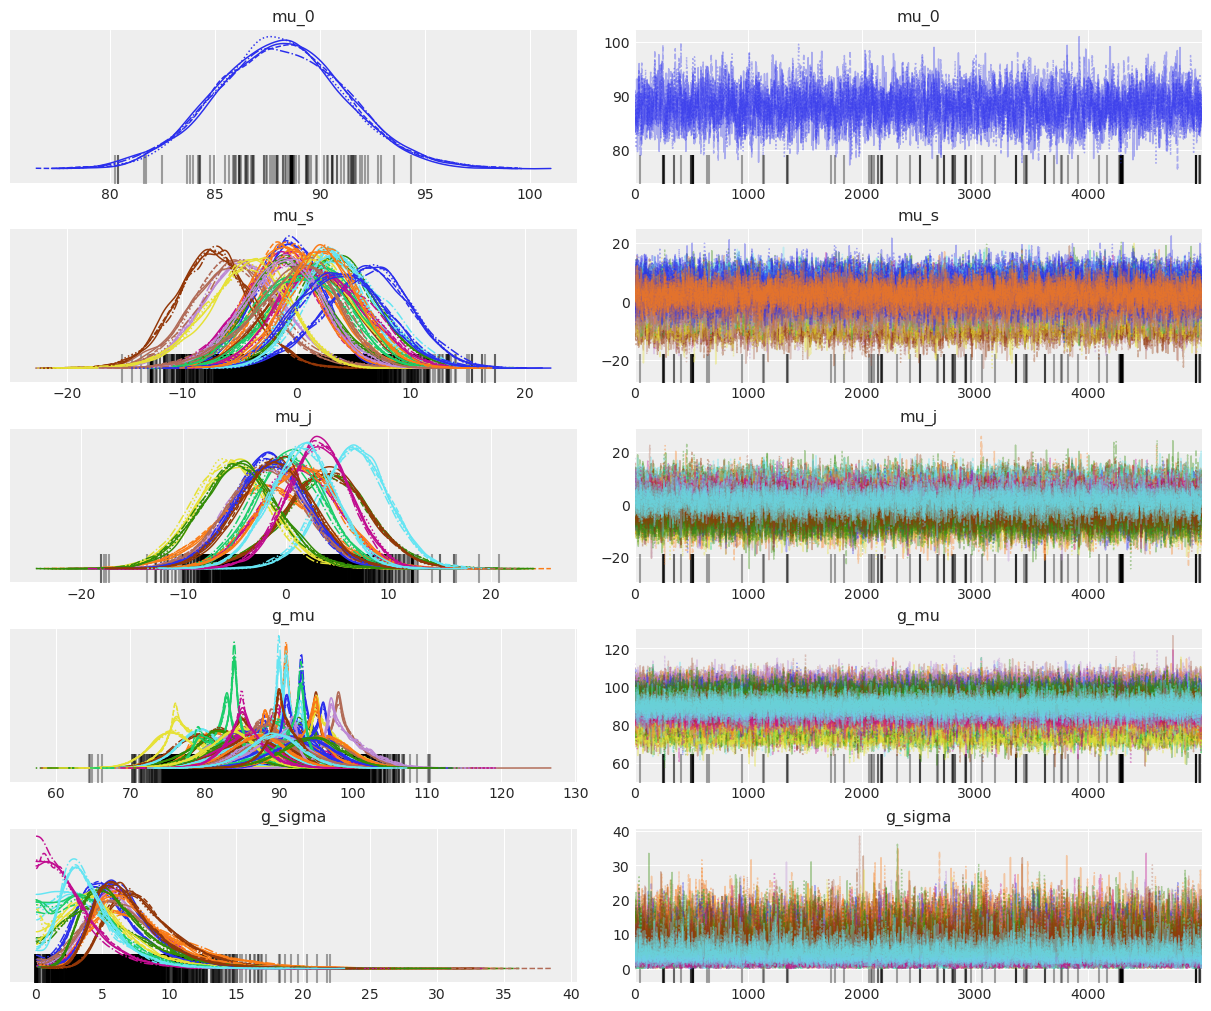

In [21]:
az.plot_trace(idata)

### Plot pairs

In [22]:
post = idata.posterior
keep_judges = [0, 1]
keep_students = [0, 1]

judge_coords = post.coords['judges']
student_coords = post.coords['students']

judge_mu_dict = {f'mu_{judge_coords[j].item()}': post['mu_j'][:,:,j] for j in keep_judges}
judge_s_dict = {f'sd_{judge_coords[j].item()}': post['g_sigma'][:,:,j] for j in keep_judges}
student_dict = {f'mu_{student_coords[s].item()}': post['mu_s'][:,:,s] for s in keep_students}

plot_data = az.from_dict(
    posterior = {'mu_0': post['mu_0'], **judge_mu_dict, **judge_s_dict, **student_dict},
    sample_stats = {'diverging': idata.sample_stats.diverging}
)

c:\Users\donchin\Anaconda3\envs\grades-for-projects-anonymized\lib\site-packages\arviz\plots\pairplot.py:194: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,


array([[<AxesSubplot:ylabel='mu_שופט 1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu_שופט 10'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sd_שופט 1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sd_שופט 10'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu_203677505'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu_0', ylabel='mu_204922249'>,
        <AxesSubplot:xlabel='mu_שופט 1'>,
        <AxesSubplot:xlabel='mu_שופט 10'>,
        <AxesSubplot:xlabel='sd_שופט 1'>,
        <AxesSubplot:xlabel='sd_שופט 10'>,
        <AxesSubplot:xlabel='mu_203677505'>]], dtype=object)

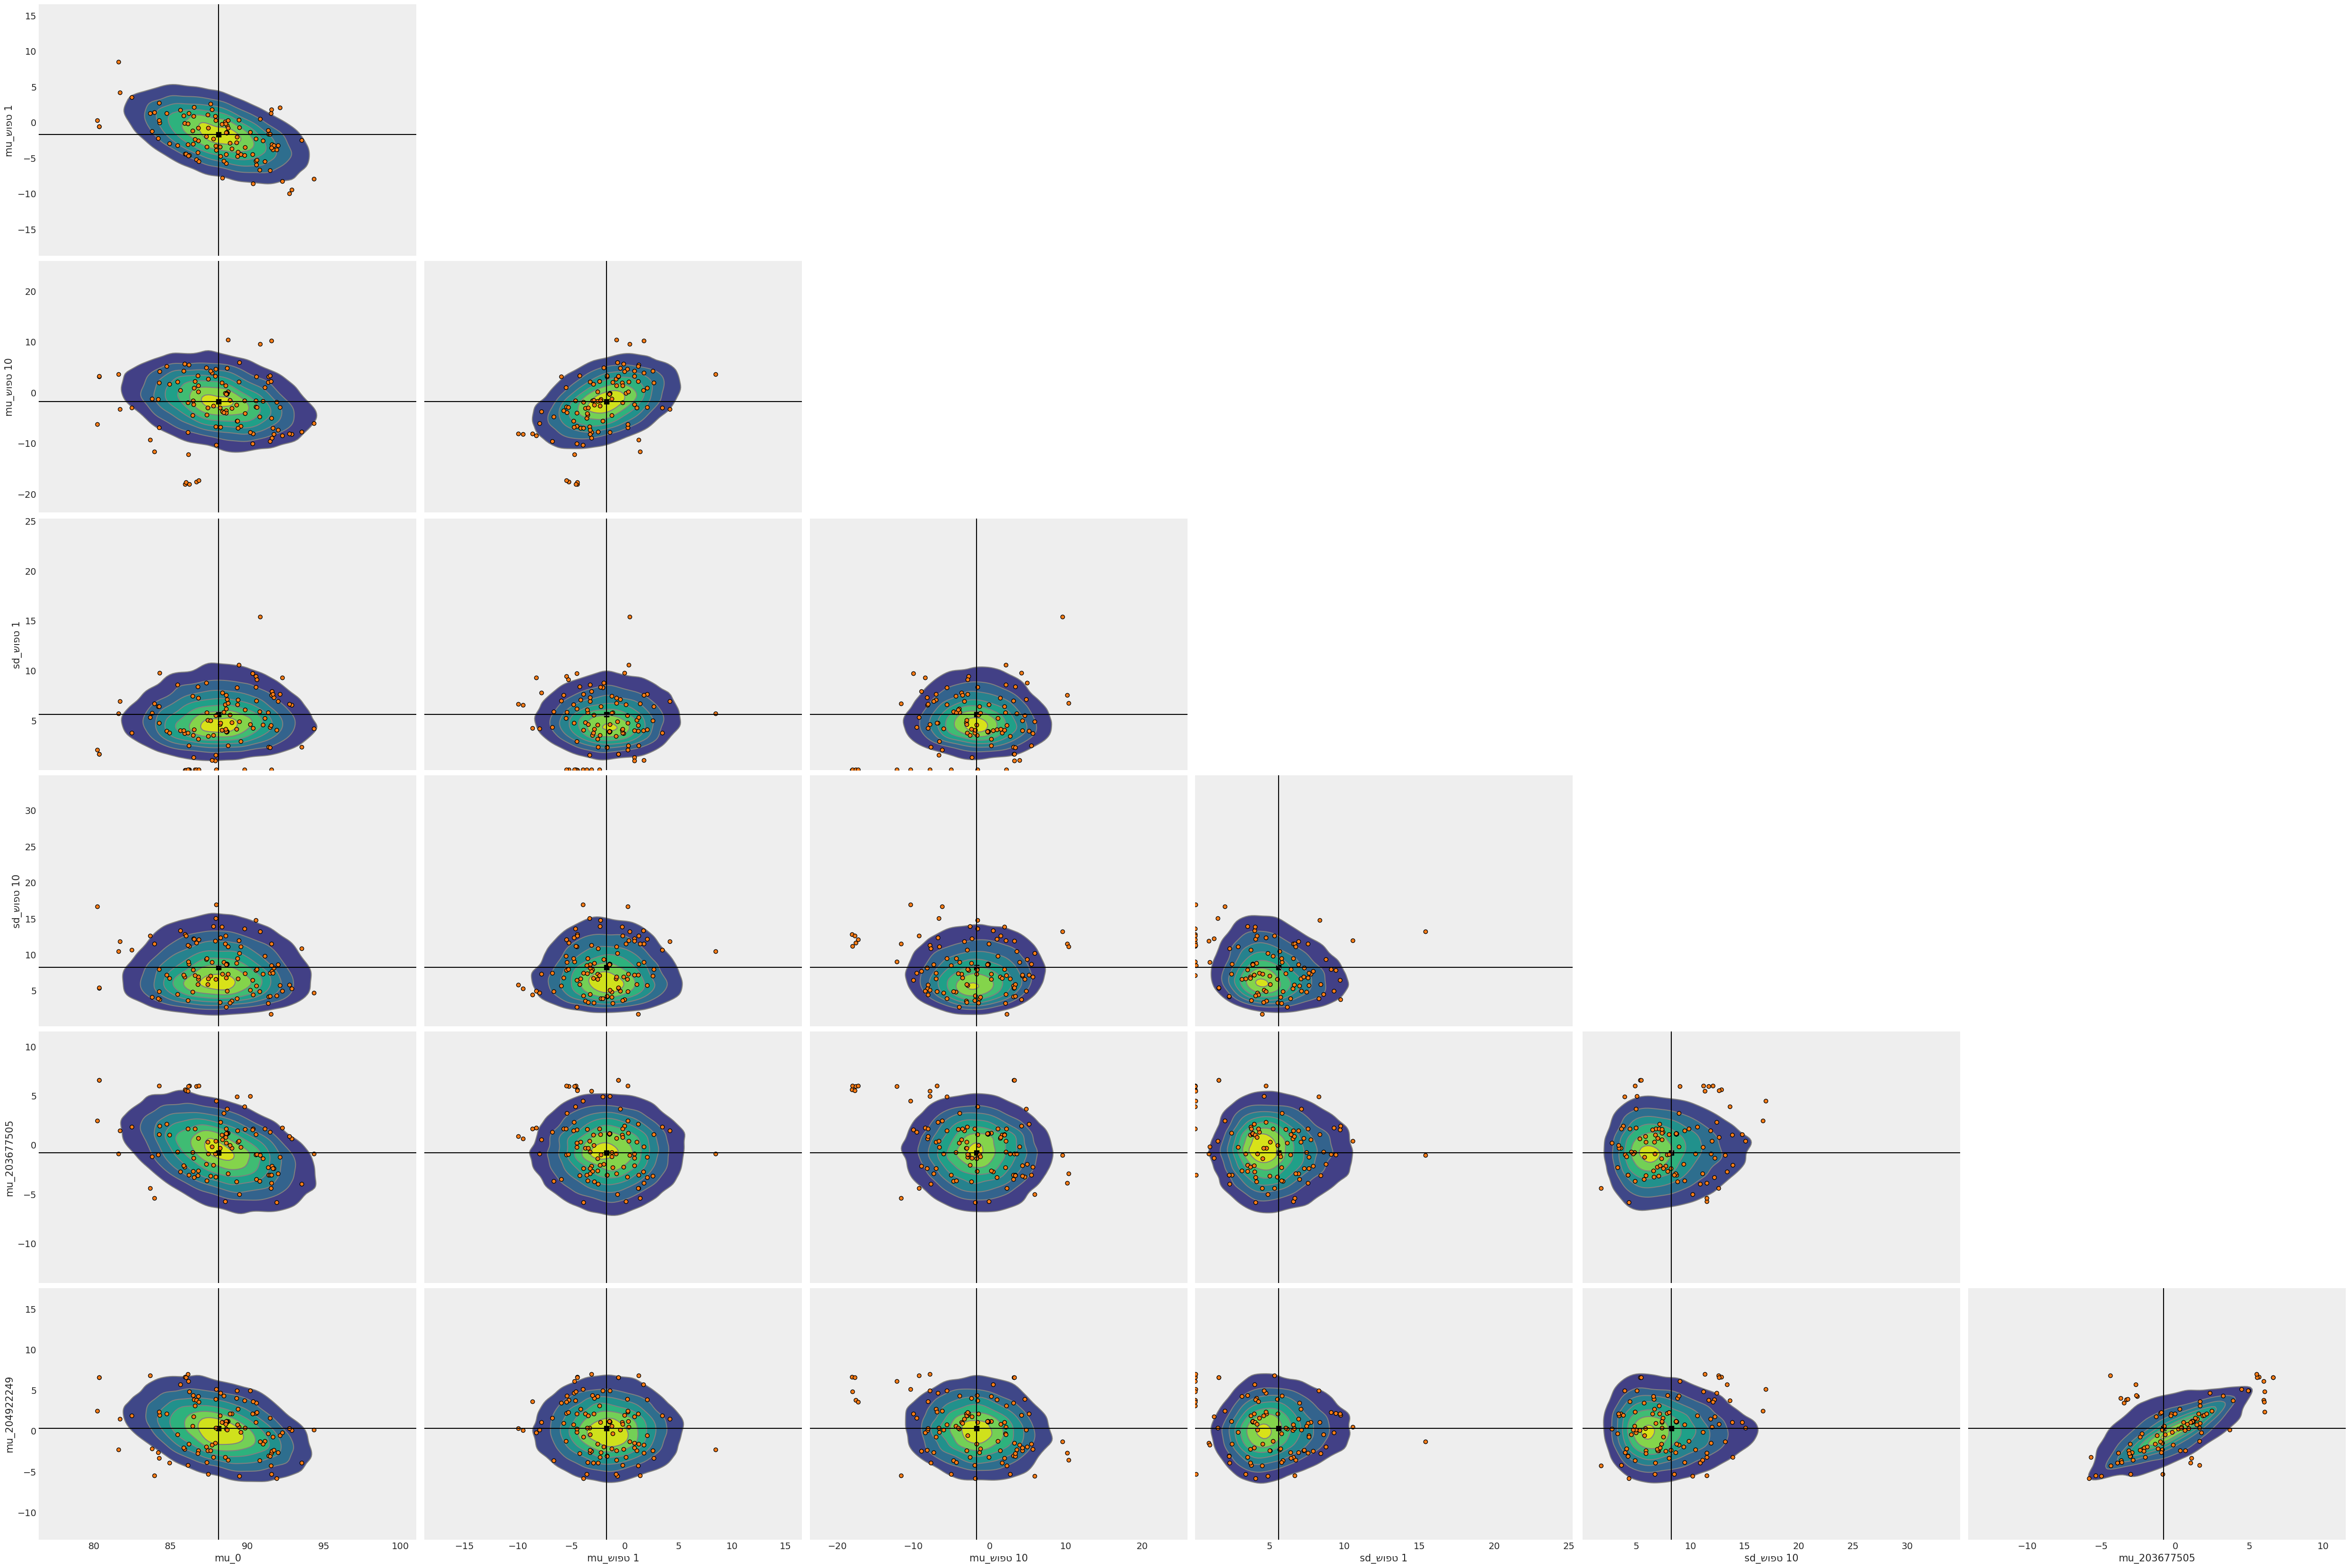

In [23]:
az.plot_pair(plot_data, kind='kde', contour=True, divergences=True, point_estimate='mean')

## Show results

### Plot judge means and estimates

Text(0.5, 1.0, 'Data mean and corrected value for each grader')

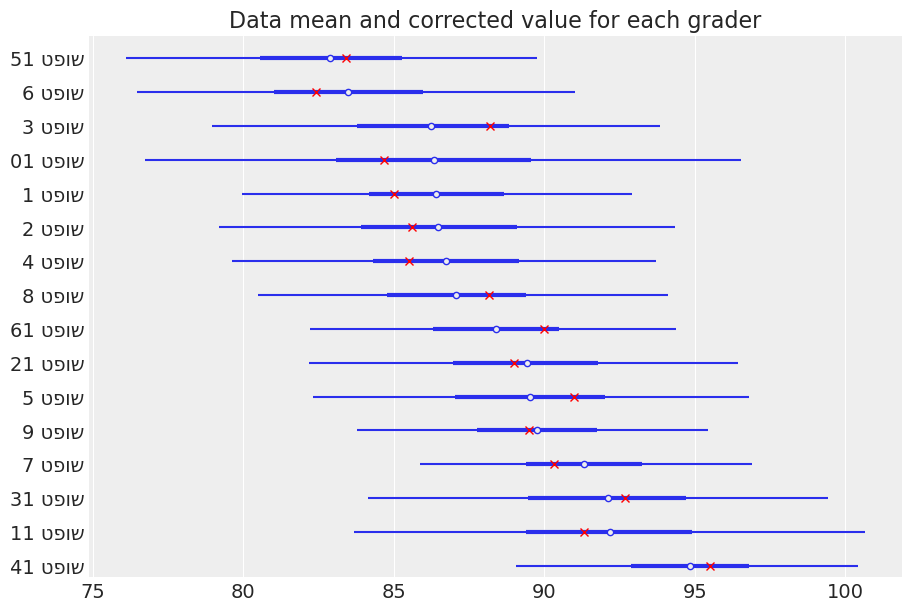

In [24]:
post = idata.posterior
mu_j = post['mu_j']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sort_order = mu_j_mean.argsort()

judge_coords = post.coords['judges']
reversed_names = [c.item()[::-1] for c in judge_coords]

mu_j_dict = {f'{reversed_names[j.item()]}': mu_j[:,:,j]+mu_0 for j in sort_order}

plot_data = az.from_dict(
    posterior = mu_j_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.j
xbar_j = [g_data[j_data==j].mean() for j in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_j, y_vals, linestyle='None', marker='x', color='r')
ax[0].set_title('Data mean and corrected value for each grader')


### Plot projects means and estimates
There are two ways to do this. 

1. Add the estimated mean to the estimated project to get a value that leaves out the judges
2. Subtract the judge mean from the scores to get a corrected score per project

The difference comes fom whether we keep the unexplained variance or discard it. Keeping it will bring up the score of teh worst project and bring
down the score of the best project. 

The current plot shows both.

Text(0.5, 1.0, 'Data mean and corrected mean of each project')

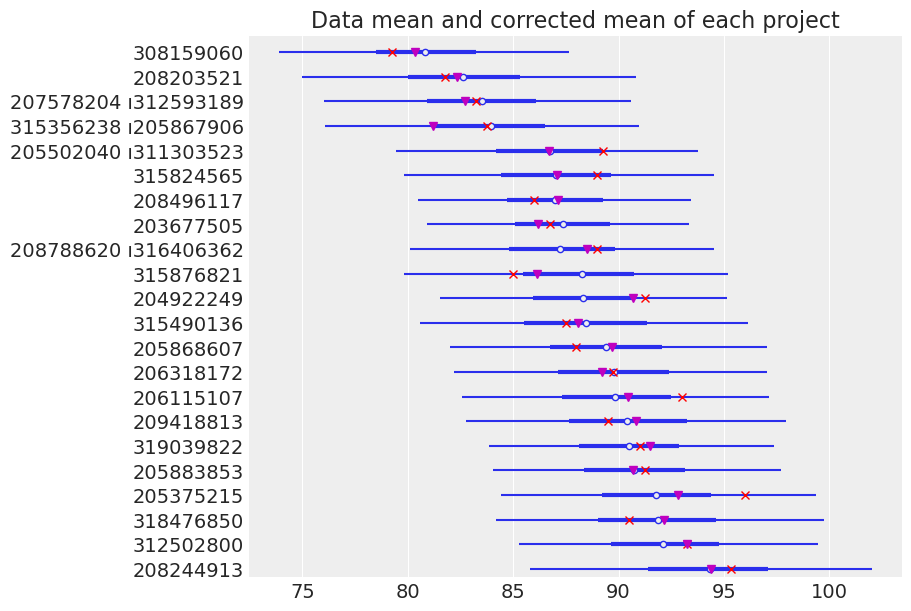

In [25]:
post = idata.posterior
mu_s = post['mu_s']
mu_0 = post['mu_0']

student_coords = post.coords['students']
reversed_names = [c.item() for c in student_coords]

mu_s_mean = mu_s.mean(dim=['chain','draw'])
sort_order = mu_s_mean.argsort()
mu_s_dict = {f'{reversed_names[s.item()]}': mu_s[:,:,s]+mu_0 for s in sort_order}

plot_data = az.from_dict(
    posterior = mu_s_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])
ax[0].set_title('Offsets of the different projects')

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.j
s_data = idata.constant_data.s

xbar_s = [g_data[s_data==s].mean() for s in sort_order.to_numpy()]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data]
xbar_s_corrected = [g_data_corrected[s_data==s].mean() for s in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_s, y_vals, linestyle='None', marker='x', color='r')
plt.plot(xbar_s_corrected, y_vals, linestyle='None', marker='v', color='m')
ax[0].set_title('Data mean and corrected mean of each project')


### Make a table of the different judges

For each judge, the table will show the projects that they judged along with their grade for that project, then the straight average of all 
the judges, then our estimated grade, and finally their grade for this project corrected by our estimated correction for them.

In [26]:
post = idata.posterior
mu_j = post['mu_j']
mu_s = post['mu_s']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
mu_s_mean_score = (mu_0 + mu_s).mean(dim=['chain', 'draw'])
sort_order_j = mu_j_mean.argsort()
sort_order_s = mu_s_mean.argsort()

judge_coords = post.coords['judges']
student_coords = post.coords['students']

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.j
s_data = idata.constant_data.s

# Data means for judges and projects
xbar_j = [g_data[j_data==j].mean() for j in sort_order_j]
xbar_s = [g_data[s_data==s].mean() for s in np.arange(len(student_coords))]



max_proj = 0
df_rows = list()
titles = ['Judge']
for j_i in sort_order_j:
    j = judge_coords[j_i]
    j_name = judge_coords[j_i].item()
    row = [j_name] # Judge name
    
    for i,s in enumerate(s_data[j_data==j_i]):
        s_i = s.item()
        s_name = student_coords[s_i].item()                      # Project name
        s_bar = xbar_s[s_i].item()                               # Project mean score
        s_j = g_data[np.logical_and(s_data == s_i, j_data == j_i)][0].item()    # Judge score
        s_mu = mu_s_mean_score[s_i].item()                       # Estimates project score
        s_j_corrected = s_j - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(s_name) 
        row.append(s_bar)
        row.append(s_j)
        row.append(s_mu)
        row.append(s_j_corrected)
        if len(row) > len(titles):
            titles.append(f'Project {i}')
            titles.append(f'Grade {i}')
            titles.append(f'Judge grade {i}')
            titles.append(f'Estimated {i}')
            titles.append(f'Corrected {i}')

    df_rows.append(row)

grader_table = pd.DataFrame(df_rows, columns=titles)
grader_table.to_csv('grader_table anonymized.csv', encoding=enc['encoding'])



In [27]:
grader_table.head()

,Judge,Project 0,Grade 0,Judge grade 0,Estimated 0,Corrected 0,Project 1,Grade 1,Judge grade 1,Estimated 1,...,Project 4,Grade 4,Judge grade 4,Estimated 4,Corrected 4,Project 5,Grade 5,Judge grade 5,Estimated 5,Corrected 5
0,שופט 15,208203521,81.75,76,82.756789,81.177753,209418813,89.50,88,90.465090,...,319039822,91.0,85.0,90.524226,90.177753,None,NaN,NaN,NaN,NaN
1,שופט 6,205868607,88.00,84,89.421883,88.579811,208496117,86.00,82,87.023107,...,318476850,90.5,89.0,91.833944,93.579811,None,NaN,NaN,NaN,NaN
2,שופט 3,205868607,88.00,88,89.421883,89.824456,209418813,89.50,92,90.465090,...,318476850,90.5,85.0,91.833944,86.824456,None,NaN,NaN,NaN,NaN
3,שופט 10,206318172,89.75,83,89.728427,84.771715,207578204 ו312593189,83.25,79,83.528201,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,שופט 1,205502040 ו311303523,89.25,81,86.708474,82.714355,206115107,93.00,93,89.936121,...,208788620 ו316406362,89.0,85.0,87.395117,86.714355,315356238 ו205867906,83.75,81.0,83.786053,82.714355


### Make a table of the different projects

For each project, the table will show the projects straight average and then our estimated score and after that, for each judge the actual score they gave, then 
each judges corrected score, and, finally, the average corrected score.

In [28]:
xbar_j = [g_data[j_data==j].mean() for j in np.arange(len(judge_coords))]
xbar_s = [g_data[s_data==s].mean() for s in np.arange(len(student_coords))]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data]
xbar_s_corrected = [g_data_corrected[s_data==s].mean() for s in np.arange(len(student_coords))]

df_rows = list()
titles = ['Project', 'Average', 'Estimated', 'Corrected']
for s_i in sort_order_s.to_numpy():
    s = student_coords[s_i]
    
    s_name = student_coords[s_i].item()
    s_bar = xbar_s[s_i].item()
    s_mu = mu_s_mean_score[s_i].item()
    s_corrected = xbar_s_corrected[s_i].item()
    
    row = [s_name, s_bar, s_mu, s_corrected] # Judge name

    for i,j in enumerate(j_data[s_data==s_i]):
        j_i = j.item()
        j_name = judge_coords[j_i].item()                      # Judge name
        j_s = g_data[np.logical_and(s_data == s_i, j_data == j_i)][0].item()    # Judge score
        j_s_corrected = j_s - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(j_name) 
        row.append(j_s)
        row.append(j_s_corrected)
        if len(row) > len(titles):
            titles.extend([f'Judge {i}', f'Grade {i}', f'Corrected {i}'])

    df_rows.append(row)

project_table = pd.DataFrame(df_rows, columns=titles)
project_table.to_csv('project_table anonymized.csv', encoding=enc['encoding'])


In [29]:
project_table.head()

,Project,Average,Estimated,Corrected,Judge 0,Grade 0,Corrected 0,Judge 1,Grade 1,Corrected 1,Judge 2,Grade 2,Corrected 2,Judge 3,Grade 3,Corrected 3
0,308159060,79.25,80.886170,80.361106,שופט 2,84,85.636006,שופט 4,80,81.408385,שופט 6,69,73.579811,שופט 7,84.0,80.820223
1,208203521,81.75,82.756789,82.324842,שופט 12,94,92.743588,שופט 15,76,81.177753,שופט 16,83,82.744416,שופט 5,74.0,72.633612
2,207578204 ו312593189,83.25,83.528201,82.737640,שופט 1,78,79.714355,שופט 10,79,80.771715,שופט 11,91,87.073160,שופט 9,85.0,83.391328
3,315356238 ו205867906,83.75,83.786053,81.218573,שופט 1,81,82.714355,שופט 12,85,83.743588,שופט 13,76,72.089377,שופט 14,93.0,86.326970
4,205502040 ו311303523,89.25,86.708474,86.718573,שופט 1,81,82.714355,שופט 12,87,85.743588,שופט 13,94,90.089377,שופט 14,95.0,88.326970
